# 第十章: On-policy Control with Approximation （基于函数逼近的同轨策略控制）

## 背景与动机

### 从预测到控制
- 第9章讨论如何用函数逼近估计 $V^\pi(s)$ 或 $Q^\pi(s, a)$ 来评估策略 $\pi$。
- 第10章的目标是优化策略 $\pi$，找到最优策略 $\pi^*$ 或近似最优策略。

### 在线策略控制
- 在线策略方法直接改进智能体当前执行的策略（如SARSA），区别于离线策略方法（如Q-learning）。

### 函数逼近的必要性
- 在大规模问题中，表格形式的 $Q(s, a)$ 不可行，需要用参数化函数 $\hat{Q}(s, a, \mathbf{w})$ 或参数化策略 $\pi(a|s, \theta)$。

## 基于价值的控制（Value-Based Control）

### 近似Q学习
- 扩展第6章的SARSA到函数逼近：
  - $\hat{Q}(s, a, \mathbf{w})$ 表示动作价值函数。
  - 更新规则（类似SARSA）：
    $$\mathbf{w} \leftarrow \mathbf{w} + \alpha [R_{t+1} + \gamma \hat{Q}(s_{t+1}, a_{t+1}, \mathbf{w}) - \hat{Q}(s_t, a_t, \mathbf{w})] \nabla_{\mathbf{w}} \hat{Q}(s_t, a_t, \mathbf{w})$$
  - 策略：从 $\hat{Q}$ 派生，如ε-贪婪。

### 线性逼近
- $\hat{Q}(s, a, \mathbf{w}) = \mathbf{w}^\top \mathbf{x}(s, a)$，特征 $\mathbf{x}(s, a)$ 表示状态-动作对。
- 更新：
  $$\mathbf{w} \leftarrow \mathbf{w} + \alpha \delta_t \mathbf{x}(s_t, a_t), \quad \delta_t = R_{t+1} + \gamma \hat{Q}(s_{t+1}, a_{t+1}, \mathbf{w}) - \hat{Q}(s_t, a_t, \mathbf{w})$$

### 挑战
- 非线性逼近（如神经网络）可能不稳定，尤其在在线策略控制中。

## 策略梯度方法（Policy Gradient Methods）

### 核心思想
- 直接参数化策略 $\pi(a|s, \theta)$（如softmax函数），通过优化参数 $\theta$ 提高预期回报。
- 不依赖价值函数，避免了逼近 $Q$ 的不稳定性。

### 目标函数
- 优化累积回报的期望：
  $$J(\theta) = \mathbb{E}_\pi [G_t] = \sum_s d^\pi(s) \sum_a \pi(a|s, \theta) Q^\pi(s, a)$$
  - $d^\pi(s)$：策略 $\pi$ 下的状态分布。
  - $Q^\pi(s, a)$：真实动作价值。

### 策略梯度定理
- $J(\theta)$ 对 $\theta$ 的梯度：
  $$\nabla_\theta J(\theta) \propto \sum_s d^\pi(s) \sum_a Q^\pi(s, a) \nabla_\theta \pi(a|s, \theta)$$
- 表明梯度与策略的变化和动作价值成正比。

### 蒙特卡洛策略梯度（REINFORCE）
- 用完整回报 $G_t$ 估计 $Q^\pi(s, a)$：
  $$\mathbf{\theta} \leftarrow \mathbf{\theta} + \alpha G_t \frac{\nabla_\theta \pi(a_t|s_t, \theta)}{\pi(a_t|s_t, \theta)}$$

$$这里， \frac{\nabla_\theta \pi(a_t|s_t,\theta)}{\pi(a_t|s_t,\theta)} = \nabla_\theta \ln \pi(a_t|s_t,\theta), \text{ 这是对数梯度的等价形式}$$

- 伪代码：
  ```
  初始化 θ
  重复（每个回合）：
      生成轨迹 s_0, a_0, r_1, ..., s_T
      对于 t = 0 到 T-1：
          计算 G_t
          θ ← θ + α G_t ∇_θ ln π(a_t|s_t, θ)
  ```

### 优点
- 直接优化策略，适用于连续动作空间。
- 对策略参数化的假设较少。

### 缺点
- 方差高（因 $G_t$ 波动大）。

## 带基线的策略梯度

### 问题
- $G_t$ 的高方差导致学习不稳定。

### 基线（Baseline）
- 引入状态价值 $V^\pi(s)$ 作为基线，减少方差：
  $$\mathbf{\theta} \leftarrow \mathbf{\theta} + \alpha (G_t - \hat{V}(s_t, \mathbf{w})) \frac{\nabla_\theta \pi(a_t|s_t, \theta)}{\pi(a_t|s_t, \theta)}$$
- $\hat{V}(s_t, \mathbf{w})$ 可通过第9章的TD学习估计。

### 效果
- $G_t - \hat{V}(s_t, \mathbf{w})$（优势函数估计）聚焦于动作的相对优劣，方差显著降低。

## Actor-Critic方法

### 概念
- 结合策略梯度（Actor）和价值估计（Critic）：
  - Actor：优化 $\pi(a|s, \theta)$。
  - Critic：估计 $Q^\pi(s, a)$ 或 $V^\pi(s)$。

### 更新
- Critic用TD误差更新：
  $$\mathbf{w} \leftarrow \mathbf{w} + \alpha \delta_t \nabla_{\mathbf{w}} \hat{V}(s_t, \mathbf{w}), \quad \delta_t = R_{t+1} + \gamma \hat{V}(s_{t+1}, \mathbf{w}) - \hat{V}(s_t, \mathbf{w})$$
- Actor用TD误差调整策略：
  $$\mathbf{\theta} \leftarrow \mathbf{\theta} + \alpha \delta_t \frac{\nabla_\theta \pi(a_t|s_t, \theta)}{\pi(a_t|s_t, \theta)}$$

### 伪代码
```
初始化 θ（策略参数）和 w（价值参数）
重复：
    s ← 初始状态
    选择 a ~ π(·|s, θ)
    执行 a，观察 r 和 s'
    δ ← r + γ V(s', w) - V(s, w)
    w ← w + α δ ∇_w V(s, w)
    θ ← θ + α δ ∇_θ ln π(a|s, θ)
    s ← s'
```

### 优点
- 在线更新，方差低于REINFORCE。
- 为现代深度RL奠定基础。

## 与前几章的联系

### 第6章（TD学习）
- SARSA的逼近版本是本章的基础。

### 第9章（预测逼近）
- Critic的 $\hat{V}(s, \mathbf{w})$ 直接沿用第9章的TD逼近。

### 第7章（n步自举）
- Actor-Critic可扩展到n步回报。

## 收敛性与实践

### 收敛性
- 线性逼近下的SARSA和Actor-Critic在适当条件下（如特征设计合理、学习率递减）可收敛。
- 非线性逼近（如神经网络）更强大但稳定性差。

### 应用
- 策略梯度适合连续动作任务（如机器人控制），Actor-Critic在游戏等领域表现优异。



## 总结

第10章通过函数逼近实现了在线策略控制，介绍了基于价值的SARSA逼近和策略梯度方法（REINFORCE、Actor-Critic）。策略梯度直接优化策略，适合复杂任务；Actor-Critic结合价值估计，降低了方差。这些方法为深度强化学习（如PPO、TRPO）奠定了基础。

Episode 0, Reward: 33.0
Episode 50, Reward: 13.0
Episode 100, Reward: 19.0
Episode 150, Reward: 40.0
Episode 200, Reward: 14.0
Episode 250, Reward: 34.0
Episode 300, Reward: 13.0
Episode 350, Reward: 23.0
Episode 400, Reward: 21.0
Episode 450, Reward: 45.0


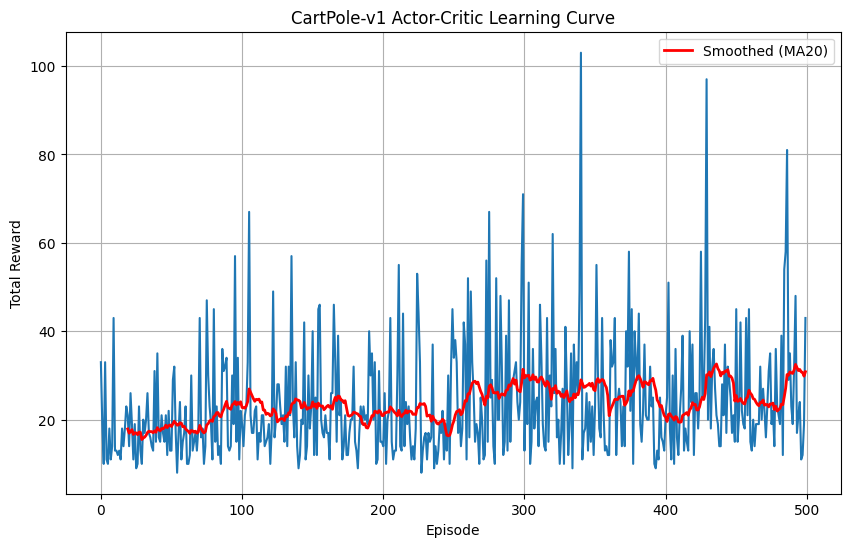

In [4]:
"""
以下是 一个简单的Actor-Critic算法实现，使用OpenAI Gym中的CartPole环境。
与表格方法相比，这个实现使用线性函数逼近来估计策略（actor）和价值函数（critic），并通过策略梯度和TD误差来更新参数。
pip install gym (或 pip install gym==0.21.0 ）
pip install numpy
pip install matplotlib
"""
import gym
import numpy as np
import matplotlib.pyplot as plt

env = gym.make('CartPole-v1')
n_actions = env.action_space.n
n_features = env.observation_space.shape[0]

# 参数
theta = np.random.randn(n_features, n_actions)  # 策略参数
w = np.random.randn(n_features)  # 价值参数
alpha_theta, alpha_w, gamma = 0.01, 0.01, 0.99

def policy(s, theta):
    logits = s @ theta
    return np.exp(logits) / np.sum(np.exp(logits))

# 用于绘图的数据
rewards_history = []

# 训练
for episode in range(500):
    s = env.reset()
    if isinstance(s, tuple):  # 处理gym新版本返回(state, info)的情况
        s = s[0]
    done = False
    total_reward = 0

    while not done:
        probs = policy(s, theta)
        a = np.random.choice(n_actions, p=probs)
        step_result = env.step(a)

        # 处理不同版本的gym返回值
        if len(step_result) == 5:  # 新gym版本返回 (s_next, r, terminated, truncated, info)
            s_next, r, terminated, truncated, info = step_result
            done = terminated or truncated
        else:  # 旧gym版本返回 (s_next, r, done, info)
            s_next, r, done, info = step_result

        # Critic更新
        v = w @ s
        v_next = w @ s_next if not done else 0
        delta = r + gamma * v_next - v
        w += alpha_w * delta * s

        # Actor更新
        grad = np.zeros_like(theta)
        for action in range(n_actions):
            # 对于选定的动作，梯度为状态向量乘以(1-概率)
            # 对于未选定的动作，梯度为状态向量乘以(-概率)
            indicator = 1.0 if action == a else 0.0
            grad[:, action] = s * (indicator - probs[action])

        # 更新策略参数
        theta += alpha_theta * delta * grad

        s = s_next
        total_reward += r

    # 记录每个episode的奖励
    rewards_history.append(total_reward)

    if episode % 50 == 0:
        print(f"Episode {episode}, Reward: {total_reward}")

env.close()

# 绘制学习曲线
plt.figure(figsize=(10, 6))
plt.plot(rewards_history)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('CartPole-v1 Actor-Critic Learning Curve')
plt.grid(True)

# 展示平滑曲线 (使用移动平均)
window_size = 20
if len(rewards_history) >= window_size:
    smoothed_rewards = np.convolve(rewards_history, np.ones(window_size)/window_size, mode='valid')
    plt.plot(range(window_size-1, len(rewards_history)), smoothed_rewards, 'r-', linewidth=2, label='Smoothed (MA{})'.format(window_size))
    plt.legend()

plt.show()

Episode 0, Reward: 12.0, Steps: 12, Alpha_theta: 0.0100, Entropy: 0.6931
Episode 50, Reward: 156.0, Steps: 156, Alpha_theta: 0.0092, Entropy: 0.0018
Episode 100, Reward: 500.0, Steps: 500, Alpha_theta: 0.0083, Entropy: 0.0001
Episode 150, Reward: 181.0, Steps: 181, Alpha_theta: 0.0075, Entropy: -0.0000
Episode 200, Reward: 217.0, Steps: 217, Alpha_theta: 0.0067, Entropy: -0.0000
Episode 250, Reward: 500.0, Steps: 500, Alpha_theta: 0.0058, Entropy: -0.0000
Episode 300, Reward: 500.0, Steps: 500, Alpha_theta: 0.0050, Entropy: -0.0000
Episode 350, Reward: 331.0, Steps: 331, Alpha_theta: 0.0042, Entropy: -0.0000
Episode 400, Reward: 500.0, Steps: 500, Alpha_theta: 0.0033, Entropy: 0.1469
Episode 450, Reward: 500.0, Steps: 500, Alpha_theta: 0.0025, Entropy: -0.0000


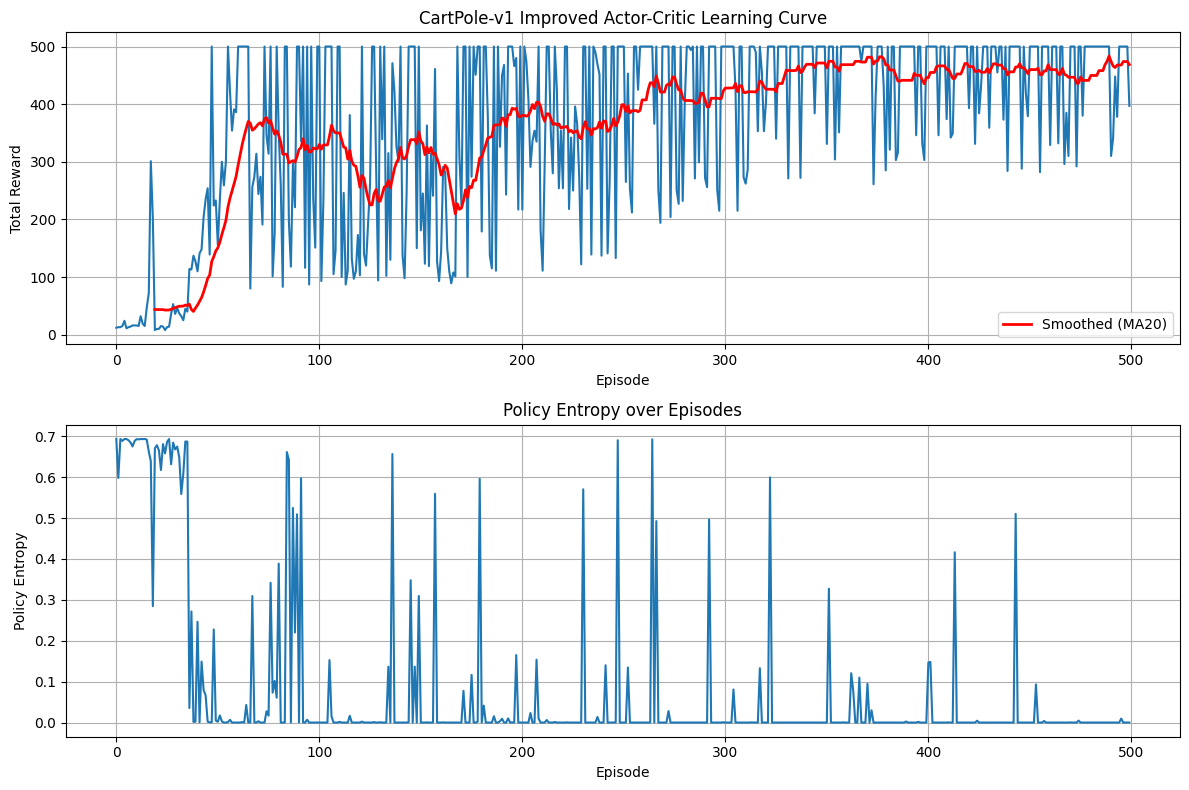

In [8]:
"""
以下是 一个简单的Actor-Critic算法实现，使用OpenAI Gym中的CartPole环境。
与表格方法相比，这个实现使用线性函数逼近来估计策略（actor）和价值函数（critic），并通过策略梯度和TD误差来更新参数。

效果：这个CartPole环境的最大奖励是500，通过训练后的结果可视化可以看到在100步左右达到了这个峰值。平均奖励在300步左右也达到峰值。

pip install gym (或 pip install gym==0.21.0 ）
pip install numpy
pip install matplotlib
"""
import gym
import numpy as np
import matplotlib.pyplot as plt

env = gym.make('CartPole-v1')
n_actions = env.action_space.n
n_features = env.observation_space.shape[0]

# 参数
theta = np.random.randn(n_features, n_actions) * 0.1  # 策略参数，使用较小的初始值
w = np.random.randn(n_features) * 0.1  # 价值参数
alpha_theta_initial, alpha_w_initial, gamma = 0.01, 0.01, 0.99 # 学习率
entropy_beta = 0.01  # 熵正则化系数

# 状态归一化
class StateNormalizer:
    def __init__(self, epsilon=1e-8):
        self.mean = np.zeros(n_features)
        self.var = np.ones(n_features)
        self.epsilon = epsilon
        self.n = 0

    def update(self, state):
        self.n += 1
        last_mean = self.mean.copy()
        self.mean += (state - self.mean) / self.n
        self.var += (state - last_mean) * (state - self.mean)

    def normalize(self, state):
        if self.n > 1:
            std = np.sqrt(self.var / (self.n - 1) + self.epsilon)
            return (state - self.mean) / std
        return state

normalizer = StateNormalizer()

def policy(s, theta):
    logits = s @ theta
    logits = logits - np.max(logits)  # 使用softmax实现数值稳定
    exp_logits = np.exp(logits)
    return exp_logits / np.sum(exp_logits)

def compute_entropy(probs):
    # 计算策略的熵，用于鼓励探索
    return -np.sum(probs * np.log(probs + 1e-10))

# 用于绘图的数据
rewards_history = []
entropy_history = []

# 训练
for episode in range(500):
    s = env.reset()
    if isinstance(s, tuple):  # 处理gym新版本返回(state, info)的情况
        s = s[0]

    # 学习率衰减
    alpha_theta = alpha_theta_initial * (1 - episode / 600)  # 从初始值线性衰减到0
    alpha_w = alpha_w_initial * (1 - episode / 600)

    done = False
    total_reward = 0
    episode_steps = 0

    # 记录这个回合的状态以用于基线计算
    episode_states = []
    episode_actions = []
    episode_rewards = []
    episode_dones = []

    while not done:
        # 数值稳定化和归一化
        normalizer.update(s)
        s_norm = normalizer.normalize(s)
        episode_states.append(s_norm)

        probs = policy(s_norm, theta)
        a = np.random.choice(n_actions, p=probs)
        episode_actions.append(a)

        step_result = env.step(a)

        # 处理不同版本的gym返回值
        if len(step_result) == 5:  # 新gym版本返回 (s_next, r, terminated, truncated, info)
            s_next, r, terminated, truncated, info = step_result
            done = terminated or truncated
        else:  # 旧gym版本返回 (s_next, r, done, info)
            s_next, r, done, info = step_result

        episode_rewards.append(r)
        episode_dones.append(done)

        s = s_next
        total_reward += r
        episode_steps += 1

    # 在整个回合结束后一次性更新参数
    G = 0
    for t in range(len(episode_states) - 1, -1, -1):
        s_t = episode_states[t]
        a_t = episode_actions[t]
        r_t = episode_rewards[t]
        done_t = episode_dones[t]

        G = r_t + gamma * G * (1 - int(done_t))

        # Critic更新
        v = w @ s_t
        delta = G - v  # TD误差，使用实际回报作为目标
        w += alpha_w * delta * s_t

        # Actor更新
        probs = policy(s_t, theta)
        grad = np.zeros_like(theta)

        for action in range(n_actions):
            indicator = 1.0 if action == a_t else 0.0
            grad[:, action] = s_t * (indicator - probs[action])

        # 添加熵正则化项
        entropy = compute_entropy(probs)
        entropy_grad = np.zeros_like(theta)
        for action in range(n_actions):
            entropy_grad[:, action] = s_t * (1 + np.log(probs[action] + 1e-10))

        # 更新策略参数（包含熵正则化）
        theta += alpha_theta * (delta * grad + entropy_beta * entropy_grad)

        if t == 0:  # 只记录每个回合的第一步的熵
            entropy_history.append(entropy)

    # 记录每个episode的奖励
    rewards_history.append(total_reward)

    if episode % 50 == 0:
        print(f"Episode {episode}, Reward: {total_reward}, Steps: {episode_steps}, "
              f"Alpha_theta: {alpha_theta:.4f}, Entropy: {entropy:.4f}")

env.close()

# 训练曲线
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(rewards_history)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('CartPole-v1 Improved Actor-Critic Learning Curve')
plt.grid(True)

# 平滑曲线 (使用MA20移动平均)
window_size = 20
if len(rewards_history) >= window_size:
    smoothed_rewards = np.convolve(rewards_history, np.ones(window_size)/window_size, mode='valid')
    plt.plot(range(window_size-1, len(rewards_history)), smoothed_rewards, 'r-', linewidth=2, label='Smoothed (MA{})'.format(window_size))
    plt.legend()

# 绘制熵变化
plt.subplot(2, 1, 2)
plt.plot(entropy_history)
plt.xlabel('Episode')
plt.ylabel('Policy Entropy')
plt.title('Policy Entropy over Episodes')
plt.grid(True)

plt.tight_layout()
plt.show()